# Calculate Distance PSD

### Build Welch method for Xaray

In [1]:
import xarray as xr
from xrsignal import xrsignal
import os
from dask.distributed import Client
import numpy as np
from scipy import signal
import dask
import scipy
from matplotlib import pyplot as plt
import xrft

%load_ext autoreload
%autoreload 2

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 62.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36357,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 62.80 GiB
Comm: tcp://127.0.0.1:39519,Total threads: 4
Dashboard: http://127.0.0.1:35637/status,Memory: 7.85 GiB
Nanny: tcp://127.0.0.1:35203,


## Calculate Distance PSD

In [3]:
# open zarr store
storage_options = {'account_name':'dasdata'}
ds = xr.open_zarr('abfs://zarr/ooi_South_Tx.zarr/ooi_South_Tx.zarr', storage_options=storage_options)

In [5]:
da = ds['RawData']

In [7]:
psd = xrsignal.welch(da, dim='time', nperseg=1024, fs=200)

In [8]:
psd_distance = psd.mean('time')

In [10]:
psd_distance.to_netcdf('/datadrive/DAS/psd_distance.nc')

2023-03-20 22:14:47,887 - distributed.spill - ERROR - Spill to disk failed; keeping data in memory
Traceback (most recent call last):
  File "/home/jhrag/anaconda3/envs/ooi_dev/lib/python3.10/site-packages/distributed/spill.py", line 114, in handle_errors
    yield
  File "/home/jhrag/anaconda3/envs/ooi_dev/lib/python3.10/site-packages/distributed/spill.py", line 188, in __setitem__
    super().__setitem__(key, value)
  File "/home/jhrag/anaconda3/envs/ooi_dev/lib/python3.10/site-packages/zict/buffer.py", line 95, in __setitem__
    self.fast[key] = value
  File "/home/jhrag/anaconda3/envs/ooi_dev/lib/python3.10/site-packages/zict/lru.py", line 74, in __setitem__
    set_()
  File "/home/jhrag/anaconda3/envs/ooi_dev/lib/python3.10/site-packages/zict/lru.py", line 71, in set_
    self.evict()
  File "/home/jhrag/anaconda3/envs/ooi_dev/lib/python3.10/site-packages/zict/lru.py", line 100, in evict
    cb(k, v)
  File "/home/jhrag/anaconda3/envs/ooi_dev/lib/python3.10/site-packages/zict/bu

## Starting From Scratch
IT WORKS 🎉

In [14]:
# open zarr store
storage_options = {'account_name':'dasdata'}
ds = xr.open_zarr('abfs://zarr/ooi_South_Tx.zarr/ooi_South_Tx.zarr', storage_options=storage_options)

In [174]:
da = ds.isel({'distance':slice(0,6000), 'time':slice(0,3000*5)})['RawData']

In [347]:
def welch_chunk(da, dim, **kwargs):
    '''
    estimate PSD for single chunk of dataarray
    
    Parameters
    ----------
    da : xr.DataArray
        single chunk data
    dim : str
        dimension that psd should be estimated in
    **kwargs
        passed to scipy.signal.welch
    '''
    
    # Create new dimensions of PSD object
    original_dims = list(da.dims)
    psd_dim_idx = original_dims.index(dim)
    
    new_dims = original_dims.copy()
    new_dims[original_dims.index(dim)] = f'{dim}_frequency'
    new_dims.append(dim)
    
    # Estimate PSD and convert to xarray.DataArray
    f, P = signal.welch(da.values, axis=psd_dim_idx, **kwargs)
    P = np.expand_dims(P,-1)
    
    Px = xr.DataArray(P, dims=new_dims)
    
    return Px

def welch(da, dim, **kwargs):
    '''
    Estimate power spectral density using welch method
    
    For now, an integer number of chunks in PSD dimension is required
    
    Parameters
    ----------
    da : xr.DataArray
        data array to estimate power spectral density
    dim : str
        dimension to calculate PSD over
    '''
    
    # Get length of PSD
    if 'nperseg' in kwargs:
        nperseg = kwargs['nperseg']
        psd_len = int(nperseg/2 + 1)
    else:
        psd_len = 129 # default value for signal.welch
    if 'nfft' in kwargs:
        nfft = kwargs['nfft']
        psd_len = int(nfft/2 + 1)
    
    # Create new dimensions of PSD object
    original_dims = list(da.dims)
    psd_dim_idx = original_dims.index(dim)
    
    new_dims = original_dims.copy()
    new_dims[original_dims.index(dim)] = f'{dim}_frequency'
    new_dims.append(dim)
    
    # Get number of chunks in each dimension
    orignal_chunksize=dict(zip(original_dims, da.data.chunksize))
    nchunks = []
    
    for k, single_dim in enumerate(original_dims):
        nchunks.append(da.shape[k]/chunksize[single_dim])
    nchunks = dict(zip(original_dims, nchunks))
    
    # raise exception if number of chunks is not integer
    if nchunks[dim]%1 != 0:
        raise Exception(f'number of chunks in dimension "{dim}" is required to be integer. there are currently {nchunks[dim]} chunks')
    # convert new dimension to integer
    nchunks[dim] = int(nchunks[dim])
    
    # Get size of every dimension
    original_sizes = dict(da.sizes)
    original_sizes[f'{dim}_frequency'] = psd_len
    
    # reorder sizes
    new_sizes = {}
    for single_dim in new_dims:
        new_sizes[single_dim] = original_sizes[single_dim]
        
    #new_sizes = original_sizes.copy()
    new_sizes[dim] = nchunks[dim]
    
    # define new chunk sizes
    new_chunk_sizes = {}
    for k, item in enumerate(new_sizes):
        if item == f'{dim}_frequency':
            new_chunk_sizes[item] = new_sizes[item]
        elif item == dim:
            new_chunk_sizes[item] = 1
        else:
            new_chunk_sizes[item] = original_chunksize[item]
    
    template = xr.DataArray(
        dask.array.random.random(list(new_sizes.values()), chunks = list(new_chunk_sizes.values())),
        dims=new_dims,
        name=f'psd across {dim} dimension')

    kwargs['dim'] = dim
    Pxx = xr.map_blocks(welch_chunk, da, template=template,  kwargs=kwargs)
    return Pxx

In [358]:
Pxx = xrsignal.welch(da, dim='time')

In [359]:
Pxx.compute()

<xarray.DataArray 'psd across time dimension' (distance: 6000,
                                               time_frequency: 129, time: 5)>
array([[[6.38244392e+10, 1.18872714e+11, 4.39953261e+10, 8.63498893e+10,
         1.73269464e+10],
        [5.28987373e+11, 6.27557735e+11, 3.53638912e+11, 2.76190925e+11,
         9.38396285e+10],
        [9.72817182e+10, 1.71188274e+11, 1.05901294e+11, 1.18006452e+11,
         3.61060019e+10],
        ...,
        [4.70438642e+02, 7.29958077e+02, 8.66864825e+02, 7.96887095e+02,
         2.92215885e+02],
        [1.53468414e+02, 2.05836057e+02, 1.38947907e+02, 2.48824207e+02,
         6.95266075e+01],
        [2.92598686e+01, 4.32586118e+01, 2.06901503e+01, 2.11542056e+01,
         1.67688709e+01]],

       [[3.89543313e+10, 1.36604325e+10, 6.08628238e+10, 3.56455864e+10,
         1.88752328e+10],
        [3.06877731e+11, 8.27353070e+10, 3.18893689e+11, 3.43102169e+11,
         1.05123231e+11],
        [8.95392412e+10, 5.18252930e+10, 1.08282407e+11, 1.05714230e+11,
         3.83583785e+10],
...
        [3.95009760e+01, 6.26682773e+01, 4.02271257e+01, 6.36927156e+01,
         5.17051700e+01],
        [1.21945291e+01, 1.19379191e+01, 1.35854803e+01, 1.77978456e+01,
         1.14561553e+01],
        [8.50103353e-01, 2.28049270e+00, 2.74927318e+00, 2.66281871e+00,
         2.66328489e+00]],

       [[2.26421238e+11, 4.97836506e+11, 3.42343842e+11, 5.11980064e+11,
         5.15879648e+11],
        [2.81490497e+13, 5.81625867e+13, 4.43064352e+13, 6.21819734e+13,
         4.01747362e+13],
        [1.54321602e+12, 2.99135120e+12, 2.35662107e+12, 3.39683292e+12,
         2.08476411e+12],
        ...,
        [5.57675761e+01, 5.73241541e+01, 3.62843946e+01, 8.36773957e+01,
         4.48516980e+01],
        [1.42915302e+01, 1.18620816e+01, 5.19855536e+00, 3.09004909e+01,
         1.40554108e+01],
        [8.42757887e-01, 1.08831460e+00, 9.00216294e-01, 3.15711878e+00,
         1.47253784e+00]]])
Dimensions without coordinates: distance, time_frequency, time

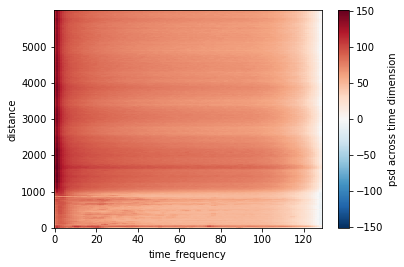

In [357]:
(10*np.log10(Pxx.mean('time').compute())).plot()

In [239]:
new_sizes

{'distance': 6000, 'time': 5, 'time_frequency': 129}

In [240]:
dim = 'time'

new_chunk_sizes = {}
for k, item in enumerate(new_sizes):
    if item == f'{dim}_frequency':
        new_chunk_sizes[item] = new_sizes[item]
    elif item == dim:
        new_chunk_sizes[item] = new_sizes[item]
    else:
        new_chunk_sizes[item] = original_chunksize[item]

distance
time
time_frequency


In [225]:
new_dims

['distance', 'time_frequency']

In [142]:
P = welch_chunk(chunk, dim='distance', fs=200, nperseg=256)

In [187]:
list(new_sizes.values())

[6000, 5, 129]

In [66]:
dim = 'time'
dims[dims.index(dim)] = f'{dim}_frequency'
print(dims)

['distance', 'time_frequency']


In [44]:
chunk = ds.isel({'distance':slice(0,3000), 'time':slice(0,3000)})['RawData']

In [47]:
PSD = welch_chunk(chunk, 'time')

In [57]:
x = ['a', 'b', 'c', 'd']
x.pop(x.index('a'))

print(x)

['b', 'c', 'd']


In [48]:
PSD.shape

(3000, 129)

In [30]:
Pxx = welch_chunk(chunk)

In [31]:
Pxx

array([[6.38244392e+10, 5.28987373e+11, 9.72817182e+10, ...,
        4.70438642e+02, 1.53468414e+02, 2.92598686e+01],
       [3.89543313e+10, 3.06877731e+11, 8.95392412e+10, ...,
        7.83936662e+02, 1.55689699e+02, 3.01510825e+01],
       [3.63092267e+10, 4.58212924e+11, 8.59343274e+10, ...,
        5.70859375e+02, 9.61301320e+01, 2.66751272e+01],
       ...,
       [3.90523896e+11, 3.16576108e+13, 1.79752403e+12, ...,
        5.36219494e+01, 1.55107666e+01, 2.07209325e+00],
       [3.85195896e+11, 3.27657608e+13, 1.91413105e+12, ...,
        8.62808410e+01, 1.82774171e+01, 2.27202282e+00],
       [3.76620123e+11, 3.51334450e+13, 2.05030402e+12, ...,
        7.73071176e+01, 1.29236499e+01, 3.71585614e+00]])

## Status:

I'm VERY close, but I'm unable to create template because it's larger than memory...

In [3]:
# open zarr store
storage_options = {'account_name':'dasdata'}
ds = xr.open_zarr('abfs://zarr/ooi_South_Tx.zarr/ooi_South_Tx.zarr', storage_options=storage_options)

In [5]:
ds_sliced = ds.isel({'time':slice(0,200*3600)})

In [6]:
spec = xrsignal.welch(ds_sliced['RawData'], dim='time')

In [9]:
spec_distance = spec.mean('time')

In [11]:
spec_distance

In [ ]:
spec_distance

## Start from Scratch
- I think it will be easier to start from scratch instead of picking up with xrsignal# open zarr store
storage_options = {'account_name':'dasdata'}
ds = xr.open_zarr('abfs://zarr/ooi_South_Tx.zarr/ooi_South_Tx.zarr', storage_options=storage_options)

In [3]:
# open zarr store
storage_options = {'account_name':'dasdata'}
ds = xr.open_zarr('abfs://zarr/ooi_South_Tx.zarr/ooi_South_Tx.zarr', storage_options=storage_options)

In [4]:
da = ds.isel({'time':slice(0,3000*10), 'distance':slice(0,3000*5)})['RawData']

In [8]:
Pxx = xrsignal.__welch_chunk(da[:3000,:3000], fs=200)

In [10]:
xrft.power_spectrum(da, dim='time', 

ValueError: Dask array only supports taking an FFT along an axis that 
has a single chunk. An FFT operation was tried on axis 1 
which has chunks (3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000). To change the array's chunks use dask.Array.rechunk.

In [23]:

template_dask = dask.array.random.random((das_data.shape[0], 512+1,10), chunks=(3000,513,1))
template_x = xr.DataArray(template_dask, dims=['distance', 'frequency', 'time'], coords={'frequency':np.linspace(0,100,513), 'distance':np.arange(0,das_data.shape[0]*2,2)})

In [25]:
psd = xr.map_blocks(xrsignal.__welch_chunk, das_data, template=template_x)

In [13]:
psd_distance = psd.mean('time')

In [15]:
psd_distance = psd_distance.compute()

In [ ]:
template_dask = dask.array.random.random(template_sizes, chunks=tuple(template_chunks))

## Old Work

In [ ]:
# open zarr store
storage_options = {'account_name':'dasdata', 'account_key':os.environ['AZURE_KEY_dasdata']}
ds = xr.open_zarr('abfs://zarr/ooi_South_Tx.zarr/ooi_South_Tx.zarr', storage_options=storage_options)

In [ ]:
das_psd = xrsignal.welch(ds['RawData'], dim='time', fs=200)

In [ ]:
das_psd_slice = xr.Dataset({'psd':das_psd.isel({'time':slice(0,13056,4)})})

In [ ]:
das_psd_slice.to_zarr('/datadrive/DAS/psd.zarr')

In [ ]:
psd = xrsignal.__welch_map(ds['RawData'].isel({'distance':slice(0,3000), 'time':slice(0,3000)}), kwargs=kwargs)

In [ ]:
plt.imshow(10*np.log10(psd), aspect='auto')

In [ ]:
sizes

In [ ]:
template_dask.shape

In [ ]:
print(coords[0].shape)
print(coords[1].shape)
print(coords[2].shape)

In [ ]:
ds['RawData'].coords['distance'][::3000]

In [ ]:
ds['RawData'].chunksizes['distance'][0]

In [ ]:
dict(ds['RawData'].chunksizes).keys()

chunks = {'time':1, 'time_frequency':psd_len, 'distance':3000}

#### Build Template

In [ ]:
dim = 'time'
psd_len = 512
f = np.arange(512)


In [ ]:
ds['RawData'][dim][::3000]

In [ ]:
ds['RawData'].chunks[0]

In [ ]:
dim = 'time'

# get number of chunks in specified dimension
dim_list = list(ds['RawData'].dims)
dim_idx = dim_list.index(dim)
_ = dim_list.pop(dim_idx)

dim_slices = dict(zip(dim_list, [0]*len(dim_list)))
n_chunks = len(ds['RawData'].isel(dim_slices).chunks[0])


dim_sizes = dict(ds['RawData'].sizes)
del dim_sizes[dim]

template_dims = [dim, f'{dim}_frequency'] + list(dim_sizes.keys())
template_sizes = []

for template_dim in template_dims:
    if template_dim == dim:
        template_sizes.append(n_chunks)
    elif template_dim == f'{dim}_frequency':
        template_sizes.append(psd_len)
    else:
        template_sizes.append(ds['RawData'].sizes[template_dim])

In [ ]:
template_sizes

In [ ]:
dim